In [1]:
#LSTM Optimisation Code
#Check for pytorch being installed
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.device_count() > 0 else "No CUDA device")

2.3.0+cu121
True
1
NVIDIA GeForce GT 1030


In [2]:
#Libraries
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import dump, load
import random
import os
import datetime

In [3]:
#Optimisation Libraries
from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.utils.measurement.synthetic_functions import branin
import torch.optim as optim
from random import uniform

In [4]:
# Set the maximum number of rows and columns to display
pd.set_option('display.max_rows', None)  # None means unlimited
pd.set_option('display.max_columns', None)  # None means unlimited

In [5]:
#Code to set the seed for reproducibility
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)  # Python random module.
    np.random.seed(seed_value)  # Numpy module.
    torch.manual_seed(seed_value)  # PyTorch to set the seed
    os.environ['PYTHONHASHSEED'] = str(seed_value)  # Python software environment.

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)  # Sets the seed for generating random numbers for the current GPU.
        torch.cuda.manual_seed_all(seed_value)  # Sets the seed for generating random numbers on all GPUs.
        torch.backends.cudnn.deterministic = True  # Forces the use of the same algorithm
        torch.backends.cudnn.benchmark = False  #Helps when input sizes do not vary.


set_seed(42)

In [6]:
#Function to filter Data
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [13]:
# Pure LSTM Model (no attention)
class PureLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(PureLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_hidden_state = h_n[-1]  # Get the last layer's hidden state (shape: [batch_size, hidden_size])
        output = self.linear(last_hidden_state)
        return output

In [8]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate RMSE, MAE, and MAPE given the true and predicted values.

    Args:
    y_true (torch.Tensor): True values.
    y_pred (torch.Tensor): Predicted values from the model.

    Returns:
    dict: Dictionary containing RMSE, MAE, and MAPE.
    """
    y_true = y_true.detach().numpy()  #y_true is a tensor, detach and convert to numpy
    y_pred = y_pred.detach().numpy()  #y_pred is a tensor, detach and convert to numpy

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE calculation

    rmse = np.sqrt(mse)  # Calculate RMSE from MSE

    metrics = {
        "RMSE": rmse,
        "MSE":mse,
        "MAE": mae,
        "MAPE": mape
    }

    return metrics

In [9]:
#Function to create sequences. LSTM is a sequence based model. It takes sequences as an input and uses it to predict future values
def create_sequences(data, seq_length, date_times):
    xs = [] #Lists to store the input sequences
    ys = [] #Lists to store the target value sequences
    dates =[]   #List to store date sequences
    for i in range(len(data)-seq_length):       #Use the filtered values to create the sequences use on the model
        x = data.iloc[i:(i+seq_length)][['PM2.5_filtered', 'PM10_filtered']].values     #A slice of the dataframe (from i to i + length of the sequence) is taken to create an input sequence
        y = data.iloc[i+seq_length][['PM2.5_filtered', 'PM10_filtered']].values
        xs.append(x)
        ys.append(y)
        dates.append(date_times.iloc[i + seq_length])
    return np.array(xs), np.array(ys), np.array(dates)

In [10]:
#Input data
'''
Add input data
'''
data = pd.read_csv(r"C:\Users\User\Code\databook\data\US\CombinedData\USCleanedPMData.csv", parse_dates=['DateTime'])



data.sort_values('DateTime', inplace=True)  # Ensure data is sorted by DateTime

# Separate DateTime for use in alignment later
date_times = data['DateTime'].reset_index(drop=True)

# Drop the DateTime column from the dataset to prepare data for the model
data = data.drop(columns=['DateTime'])

cutoff = 0.1  # Desired cutoff frequency of the filter, Hz
fs = 1.0  # Sample rate, Hz
data['PM2.5_filtered'] = butter_lowpass_filter(data['PM2.5'], cutoff, fs)
data['PM10_filtered'] = butter_lowpass_filter(data['PM10'], cutoff, fs)
data[['PM2.5_filtered', 'PM10_filtered']] = data[['PM2.5_filtered', 'PM10_filtered']].clip(lower=0) #data clipped since PM data can never be negative

#Set data split percentages
TRAIN_SIZE = 0.6    #60% for training
TEST_VALIDATION_SPLIT = 0.4  #%40 for validation
EVEN_SPLIT = 0.0    #No testing is done


# Fit scaler only on the training portion of the dataset
train_index = int(len(data) * TRAIN_SIZE)
scaler = MinMaxScaler()
scaler.fit(data[['PM2.5_filtered', 'PM10_filtered']].iloc[:train_index])

# Apply scaler to training data
data[['PM2.5_filtered', 'PM10_filtered']] = scaler.transform(data[['PM2.5_filtered', 'PM10_filtered']])

# Create seqeunces
seq_length = 24
x, y, dates = create_sequences(data, seq_length, date_times)


# Split the full dataset into training and a temporary holding set for further splitting
x_train, x_val, y_train, y_val, dates_train, dates_val = train_test_split(
    x, y, dates,
    test_size=TEST_VALIDATION_SPLIT, 
    random_state=42,
    shuffle=False
)

# Shuffle the training set to enhance model generalization
# This can be done by re-indexing the training set with a permutation of indices
indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
dates_train = dates_train[indices]

'''
# Further split the temporary dataset into validation and test sets
x_val, x_test, y_val, y_test, dates_val, dates_test = train_test_split(
    x_temp, y_temp, dates_temp,
    test_size=TEST_SPLIT,    
    random_state=42,
    shuffle=False
)
'''

#Use GPU for tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Convert to PyTorch tensors and move them to the correct device
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
#test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Used to create batches from a dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


cuda


In [11]:
def train_lstm_with_hyperparams_small_models(params):


    """
    Train the LSTM model with the given hyperparameters and return validation loss.
    """
    input_size = 2  # PM2.5 & PM10
    hidden_size = int(params["hidden_size"])
    num_layers = int(params["num_layers"])
    learning_rate = params["learning_rate"]
    

    # Define the model
    model = PureLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=2, dropout=0)
    model.to("cuda" if torch.cuda.is_available() else "cpu")

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model (Simplified Training Loop)
    num_epochs = 5  # Use a low number for quick evaluation
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()

    return val_loss / len(val_loader)  # Return average validation loss


In [14]:
#Random Search Optimisation - Small Models
best_loss = float("inf")
best_params = None

# Store all losses to analyze variance
random_search_results = []

for i in range(50):  # Run 50 trials with random search
    parameters = {
        "hidden_size": int(uniform(50, 120)),
        "num_layers": int(uniform(1, 2)),
        "learning_rate": round(uniform(1e-4, 1e-2), 5),  # Round to 5 decimal places
        #"dropout": 0,  # Round to 2 decimal places
        #"weight_decay": 0,  # Round to 5 decimal places
    }
    val_loss = train_lstm_with_hyperparams_small_models(parameters)
    result = parameters.copy()
    result["val_loss"] = val_loss
    result["run"] = i + 1
    random_search_results.append(result)
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_params = parameters

    print(f"Run number: {i+1} | Validation Loss: {val_loss}")
    print(f"Current best loss: {best_loss}")

# Compute overall stats
losses = [res["val_loss"] for res in random_search_results]
mean_loss = np.mean(losses)
std_dev_loss = np.std(losses)
variance_loss = np.var(losses)

print(f"\nMean Validation Loss: {mean_loss:.6f}")
print(f"Standard Deviation: {std_dev_loss:.6f}")
print(f"Variance: {variance_loss:.6f}")
print("Best  Validation Loss:", best_loss)
print(f"\nBest Parameters: {best_params}")



Run number: 1 | Validation Loss: 2.5825961627073087e-05
Current best loss: 2.5825961627073087e-05
Run number: 2 | Validation Loss: 6.0737218178293884e-05
Current best loss: 2.5825961627073087e-05
Run number: 3 | Validation Loss: 1.3185273641330732e-05
Current best loss: 1.3185273641330732e-05
Run number: 4 | Validation Loss: 2.5053162792801814e-05
Current best loss: 1.3185273641330732e-05
Run number: 5 | Validation Loss: 1.2270974298204273e-05
Current best loss: 1.2270974298204273e-05
Run number: 6 | Validation Loss: 6.576566866796974e-05
Current best loss: 1.2270974298204273e-05
Run number: 7 | Validation Loss: 9.92340440412494e-06
Current best loss: 9.92340440412494e-06
Run number: 8 | Validation Loss: 1.4434940279628809e-05
Current best loss: 9.92340440412494e-06
Run number: 9 | Validation Loss: 9.108133914465342e-06
Current best loss: 9.108133914465342e-06
Run number: 10 | Validation Loss: 2.4127459034781684e-05
Current best loss: 9.108133914465342e-06
Run number: 11 | Validation L

In [15]:
# Save results to CSV
# Get the current time
current_time = datetime.datetime.now().time()

TIME = current_time.strftime("%H-%M-%S")
results_df = pd.DataFrame(random_search_results)
results_df.to_csv(f"C:/Users/User/Lab/Global Air Pollution/Results/Opt/PureLSTM_smallmodels_random_search_results_{TIME}.csv", index=False)
print("\nResults saved")


Results saved


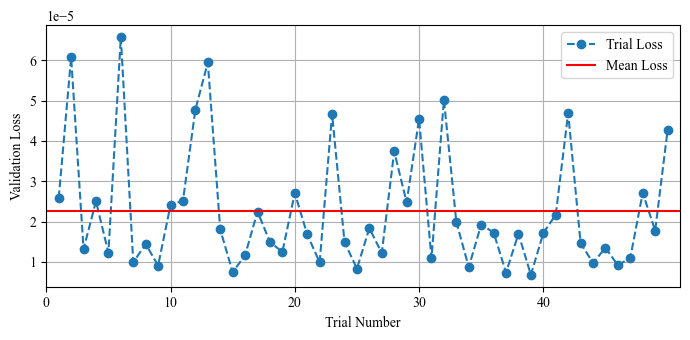

In [16]:
#Plot the graph
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(7,3.5))
plt.plot(range(1, len(losses) + 1), losses, marker="o", linestyle="--", label="Trial Loss")
plt.axhline(y=mean_loss, color='r', linestyle='-', label="Mean Loss")
plt.xlabel("Trial Number",  fontsize=10 , fontname='Times New Roman')
plt.ylabel("Validation Loss",  fontsize=10 , fontname='Times New Roman')
plt.legend()
plt.xticks(np.arange(len(losses), step=10, dtype=int))
plt.xticks(rotation=0)
plt.xlim(0, len(losses)+1)

plt.grid()
plt.tight_layout()

path = f'C:/Users/User/Lab/Global Air Pollution/Results/Opt/PureLSTM_Small_Models_Validation_Loss_{TIME}'
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 

plt.show()

In [17]:
def train_lstm_with_hyperparams_complex_models(params):
    """
    Train the LSTM model with the given hyperparameters and return validation loss.
    """
    input_size = 2  # PM2.5 & PM10
    hidden_size = int(params["hidden_size"])
    num_layers = int(params["num_layers"])
    learning_rate = params["learning_rate"]
    dropout = params["dropout"]
    weight_decay = params["weight_decay"]

    # Define the model with dropout
    model = PureLSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=2,
        dropout=dropout
        
    )
    model.to("cuda" if torch.cuda.is_available() else "cpu")

    # Define loss function and optimizer with weight decay
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

    # Train the model (Simplified Training Loop)
    num_epochs = 5  # Use a low number for quick evaluation
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()

    return val_loss / len(val_loader)

In [18]:
#Random Search Optimisation - Complex Models - REMEMBER TO CHANGE THE MODEL TO ADD EXTRA PARAMETERS
best_loss = float("inf")
best_params = None

# Store all losses to analyze variance
random_search_results = []

for i in range(50):  # Run 50 trials with random search
    parameters = {
        "hidden_size": int(uniform(50, 200)),
        "num_layers": int(uniform(2, 4)),
        "learning_rate": round(uniform(1e-4, 1e-2), 5),  # Round to 5 decimal places
        "dropout": round(uniform(0.1, 0.5), 2),  # Round to 2 decimal places
        "weight_decay": round(uniform(1e-5, 1e-3), 5),  # Round to 5 decimal places
    }
    val_loss = train_lstm_with_hyperparams_complex_models(parameters)
    result = parameters.copy()
    result["val_loss"] = val_loss
    result["run"] = i + 1
    random_search_results.append(result)
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_params = parameters

    print(f"Run number: {i+1} | Validation Loss: {val_loss}")
    print(f"Current best loss: {best_loss}")

# Compute overall stats
losses = [res["val_loss"] for res in random_search_results]
mean_loss = np.mean(losses)
std_dev_loss = np.std(losses)
variance_loss = np.var(losses)

print(f"\nMean Validation Loss: {mean_loss:.6f}")
print(f"Standard Deviation: {std_dev_loss:.6f}")
print("Best  Validation Loss:", best_loss)
print(f"Variance: {variance_loss:.6f}")
print(f"\nBest Parameters: {best_params}")


Run number: 1 | Validation Loss: 0.002883523114109145
Current best loss: 0.002883523114109145
Run number: 2 | Validation Loss: 0.0027862673956247355
Current best loss: 0.0027862673956247355
Run number: 3 | Validation Loss: 0.002815370987786077
Current best loss: 0.0027862673956247355
Run number: 4 | Validation Loss: 0.0027807464178274044
Current best loss: 0.0027807464178274044
Run number: 5 | Validation Loss: 0.0028060727310063194
Current best loss: 0.0027807464178274044
Run number: 6 | Validation Loss: 0.0029094319814153675
Current best loss: 0.0027807464178274044
Run number: 7 | Validation Loss: 0.002786733086414215
Current best loss: 0.0027807464178274044
Run number: 8 | Validation Loss: 0.00285097396083776
Current best loss: 0.0027807464178274044
Run number: 9 | Validation Loss: 0.0029297165009214035
Current best loss: 0.0027807464178274044
Run number: 10 | Validation Loss: 0.0028100109789928303
Current best loss: 0.0027807464178274044
Run number: 11 | Validation Loss: 0.001300247

In [19]:
# Save results to CSV
# Get the current time
current_time = datetime.datetime.now().time()

TIME = current_time.strftime("%H-%M-%S")
results_df = pd.DataFrame(random_search_results)
results_df.to_csv(f"C:/Users/User/Lab/Global Air Pollution/Results/Opt/PureLSTM_complexmodels_random_search_results_{TIME}.csv", index=False)
print("\nResults saved")


Results saved


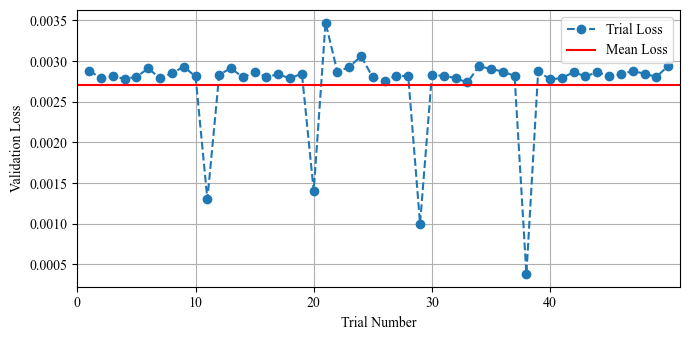

In [20]:
#Plot the graph
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(7,3.5))
plt.plot(range(1, len(losses) + 1), losses, marker="o", linestyle="--", label="Trial Loss")
plt.axhline(y=mean_loss, color='r', linestyle='-', label="Mean Loss")
plt.xlabel("Trial Number",  fontsize=10 , fontname='Times New Roman')
plt.ylabel("Validation Loss",  fontsize=10 , fontname='Times New Roman')
plt.legend()
plt.xticks(np.arange(len(losses), step=10, dtype=int))
plt.xticks(rotation=0)
plt.xlim(0, len(losses)+1)

plt.grid()
plt.tight_layout()

path = f'C:/Users/User/Lab/Global Air Pollution/Results/Opt/PureLSTM_Complex_Models_Validation_Loss_{TIME}'
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 

plt.show()